# Calculos del radio de la parte neutra

En esta libreta queremos estimar el radio para la parte neutra de los glóbulos. Para esto vamos a tomar el combo D quela emisión neutra.
Algo que debemos tomar en cuenta es que todos los combos se hicieron tomando convolución para la resolución de f440m.


## Llamado de paqueterías y localización de los glóbulos



In [1]:
from astropy.io import fits
import pyregion
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as cte 
import regions
from astropy.wcs import WCS
import cmasher as cm
import seaborn as sn
from discrete_gaussian_model import DiscreteGaussianModel
from astropy.nddata import Cutout2D
from astropy.coordinates import Angle
from astropy.modeling import models, fitting
from astropy.modeling.models import Const1D
from astropy.table import QTable, Table
from astropy.coordinates import SkyCoord
FITTER = fitting.LevMarLSQFitter()

In [2]:
'''Primero cargamos las ubicacionees de los globules que se encuentran en la carpeta M1-67'''
regs = regions.Regions.read('m1-67-globules.reg', format="ds9")
regs = [_ for _ in regs if hasattr(_, 'center') and _.visual.get('marker') == "o"]

c0 = SkyCoord.from_name('wr124', cache=True)

source_table = QTable(
    [
        {"ICRS": r.center, "Isolated": r.visual.get('markeredgewidth') == 3} 
        for r in regs
    ]
)

source_table["PA"] = c0.position_angle(source_table["ICRS"]).to(u.deg)
source_table["Sep"] = source_table["ICRS"].separation(c0).to(u.arcsec)
source_table["PA"].info.format = ".2f"
source_table["Sep"].info.format = ".2f"

##  Clase

La definición de esta clase es similar a la de otras libretas solo que en esta ocasión vamos a cambiar la máscara sobre la que trabajaremos.

En esta ocasión la máscara funcionará de la siguiente manera:
 * Encontraremos el pico de emisión, esto ya que en si tomabamos el promedio del flujo en ocasiones se veía afectado en algunos glóbulos que tenían emisión neutra de otras fuentes que estuvieran cerca.
 * Alrededor de este pico vamos a tener un pequeño círculo para que tenga parte de la emisión neutra en todods los ángulos.
 * y después tendremos dos conos. Estos conos tendrán un ángulo pequeño y serán perpendiculares al eje de simetría cnsiderado en el modelo.

Con esto pretendemos medir un radio que sea perpendicular al eje de simetría considerado en el modelo. 

In [3]:
class SourceCutout:
    """Small image cut out around a given source
    """
    
    def __init__(self, pdata, hdu, size=3 * u.arcsec):
        self.center = pdata["ICRS"]
        # PA of source wrt star
        self.pa_source = pdata["PA"]
        # and PA of star wrt source
        self.pa_star = Angle(self.pa_source + 180 * u.deg).wrap_at(360 * u.deg)
        self.sep = pdata["Sep"]
        self.is_isolated = pdata["Isolated"]
        self.size = size
        self.cutout = Cutout2D(
            hdu.data, position=self.center, size=size, wcs=WCS(hdu), copy=True,
        )
        self.image = self.cutout.data
        self.wcs = self.cutout.wcs
        ny, nx = self.image.shape
        self.x, self.y = np.meshgrid(np.arange(nx), np.arange(ny))
        self.image_coords = self.wcs.pixel_to_world(self.x, self.y)
        #self.cero = self.image[self.cutout.mask][0]
        # Radius and PA of each pixel with respect to the NOMINAL center
        self.r = self.center.separation(self.image_coords)
        self.pa = self.center.position_angle(self.image_coords)
        # Default mask has max radius of half the cutout size
        self.set_mask(r_out=self.size / 2)

        self.find_bary_center()
        # Recalculate r, pa, and masks wrt the barycenter
        self.r = self.barycenter.separation(self.image_coords)
        self.pa = self.barycenter.position_angle(self.image_coords)
        self.set_mask(r_out=self.size / 2)

        # And do photometry
        self.bright_peak = np.max(self.image[self.coremask])
        # Take the 10% centile as estimate of BG value
        self.bright_bg = np.percentile(
            self.image[self.mask],
            10,
        )
        # BG-subtracted of the core region
        self.flux_core = np.sum((self.image - self.bright_bg)[self.coremask])
        # BG-subtracted part of the outer part within the mask but excluding core
        self.flux_halo = np.sum(
            (self.image - self.bright_bg)[(~self.coremask) & self.mask]
            )
        
    def __repr__(self):
        return f"SourceCutout({self.pa_source:.1f}, {self.sep:.1f})"
       
         
    def set_mask(
        self,
        r_out = 2.0 * u.arcsec,
        r_in = 0.2 * u.arcsec,
        r_core = 0.1 * u.arcsec,
        mu_min = 0.98,
    ):
        cth =  np.cos(90*u.degree-(self.pa - self.pa_star))
        self.mask = (self.r <= r_out) & ((cth >= mu_min) | (self.r <= r_in)) | ((-cth >= mu_min) | (self.r <= r_in))
        self.coremask = (self.r <= r_in)

    def find_bary_center(self):
        """Refine estimate of center by using flux-weighted mean
        position within the core mask
        """
        m = self.coremask

        #Original version was flux-weighted mean
        #xbary = np.average(self.x[m], weights=self.image[m])
        #ybary = np.average(self.x[m], weights=self.image[m])

        # New version is just the peak pixel
        index = np.argmax(self.image[m], axis=None)
        xbary = self.x[m][index]
        ybary = self.y[m][index]

        self.barycenter = self.wcs.pixel_to_world(xbary, ybary)

## Ajuste

De manera similar al ajuste de las dos gaussianas a las observaciones del HST vamos a hacerlo a la emisión neutra. Pero en esta ocasión vamos a ajustar solo una gaussiana y una constante. Esto ya que aquí solo veremos la emisión neutra por lo que no podremos ver la cáscara chocada y no tendría sentido el ajuste de dos gaussianas. 

En este caso para evitar que la emisión de otras fuentes afecten el cálculo de radio vamos a decir que el peso como $r^{-3}$ ya que esperamos que toda la emisión se concentre cerca del pico de emisión. Además este valor nos dió un mejor ajuste en general.

In [4]:
def fit_to_cutout(cutout):
    g0 = DiscreteGaussianModel(
        amplitude=2.0, mean=0.0, stddev=0.1, 
        bin_width=0.1, fixed={"bin_width": True},
        )
    g0.mean.fixed = True
    g0.stddev.bounds = 0.01, 0.5
    g0.amplitude.bounds = 0.01, 15

    c0 = Const1D(amplitude=cutout.bright_bg)
    c0.amplitude.bounds = 0.0, 1.5 * cutout.bright_bg

    model = g0 + c0
        
    '''Pruebas para quitar los puntos que son mas brillantes y nos pueden estorbar'''
    blimit = cutout.bright_peak      #encontrar el pico
    bm = cutout.image < blimit     # Es un operador que nos da solo los menores
    m = cutout.mask & bm           #Es el  operador logico 'and'
    b = cutout.image[m]
    r = cutout.r[m].arcsec

    th = Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg)[m]
    w = np.cos(th)**2 / (0.3 + r)**3

    cutout.fitted = FITTER(model, r, b, weights=w)
    cutout.core_sigma = cutout.fitted.stddev_0.value
    cutout.core_peak = cutout.fitted[0](0.0)
    cutout.bg_fit_level = cutout.fitted.amplitude_1.value

Ahora veremos como es la máscara en el ajuste que vamos a hacer

Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


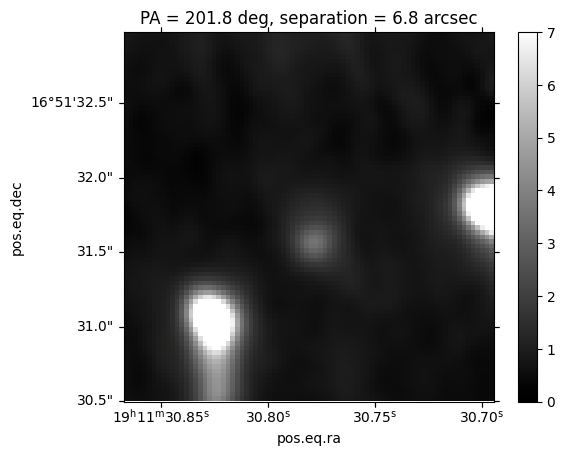

In [6]:
''' Asi se ve sol la fuente '''
filter_ = fits.open('//home/rreyes/Downloads/combo-D-neutral.fits')
hdu = filter_['SCI']
wcs = WCS(hdu)

j1, i1 = wcs.world_to_array_index(source_table[2]['ICRS'])
size = 40
yslice, xslice = slice(j1 - size, j1 + size), slice(i1 - size, i1 + size)
cutout = hdu.data[yslice, xslice]
wcutout = wcs.slice((yslice, xslice))

fig = plt.figure()
ax = fig.add_subplot(projection=wcutout)
im = ax.imshow(cutout, vmin=0.0, cmap=cm.neutral,vmax=7)
cb = fig.colorbar(im, ax=ax)
ax.set_title(f"PA = {source_table[0]['PA']:.1f}, separation = {source_table[0]['Sep']:.1f}")
...;

Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Text(0.5, 1.0, 'PA = 191.9 deg, separation = 6.6 arcsec')

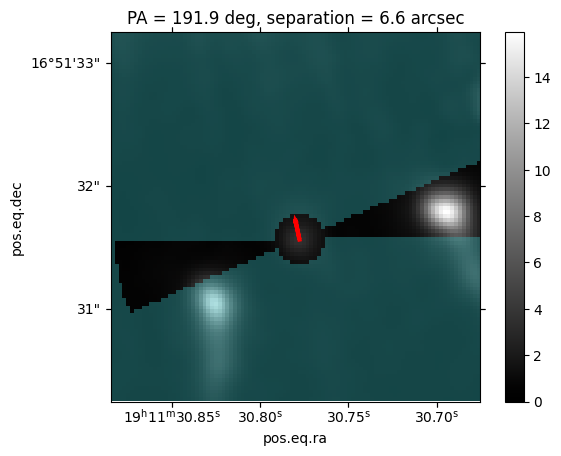

In [9]:
''' Máscara a los glóbulos '''
source = source_table[2]
cutout = SourceCutout(source, hdu)

fig = plt.figure()
ax = fig.add_subplot(projection=cutout.wcs)
im = ax.imshow(
    cutout.image,
    vmin=0.0, 
    cmap=cm.neutral,
    )
cb = fig.colorbar(im, ax=ax)
ax.imshow(np.where(cutout.mask, np.nan, 1.0), vmin=0, vmax=1, cmap=cm.gem, alpha=0.3)
y1, x1 = cutout.wcs.world_to_array_index(cutout.barycenter)
arrow_length = 5.0
dx, dy = -arrow_length * np.sin(cutout.pa_star), arrow_length * np.cos(cutout.pa_star)
ax.arrow(x1, y1, dx, dy, color='r', lw=3)
ax.set_title(f"PA = {cutout.pa_source:.1f}, separation = {cutout.sep:.1f}")

Aquí vemos las cuatro partes de la máscara
 * El pico de emisión se encuentra en el centro.
 * La flecha roja es el eje de simetría en el modelo.
 * El círculo pequeño es una estimación de donde debería estar gran parte o toda la emisión neutra del glóbulo. Tiene un radio de 0.1 arcsec
 * Las 'alas' son los conos perpendiculares al eje de simetría con una longitud de 1.5 arcsec

Para los conos se eligió esta distancia igual a la usada anteriormente porque si era más pequeño, entonces el código no detectaba muy bien cual era el valor de la constante y por lo tanto hacía un mal ajuste al tamaño del radio.

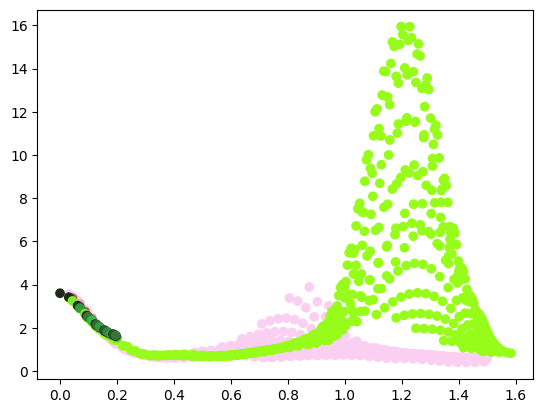

In [10]:
fig, ax = plt.subplots()
m = cutout.mask
ax.scatter(
    cutout.r[m].arcsec, 
    cutout.image[m], 
    c=Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg).deg[m], 
    vmin=-60, vmax=60,
    cmap=cm.watermelon)

En este ejemplo se ve mejor el porqué se eligió esta máscara.

En primer lugar vemos como a la emisión dentro del círculo pequeño se le puede ajustar una gaussiana y por otro lado lejos de este vemos la contaminación de la emisión neutra de otros glóbuos o fuentes, en algunos casos esta contaminación estaba muy cerca y era lo que afectaba a la constante ajustada y también la razón por la que en radio debía caer muy rápido el peso. La caída del peso en ángulo no afectaba mucho debido a que los conos en la mácara no tenían una gran variación en ángulo.

Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 1653849940.851 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.535128 from OBSGEO-[XYZ].
Set OBSGEO-H to 

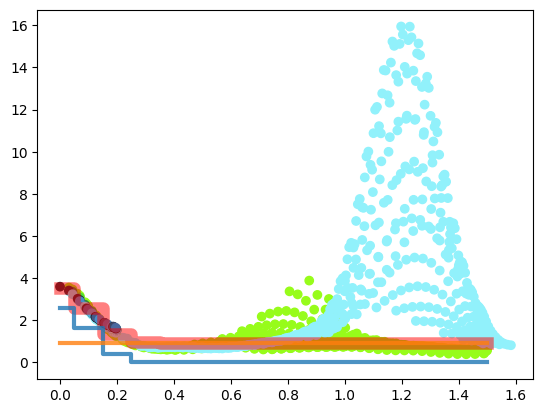

In [12]:
cutouts = [SourceCutout(source, hdu) for source in source_table]
cutouts = sorted(cutouts, key=lambda x: x.sep.value)

best_cutouts = [cutout for cutout in cutouts if cutout.is_isolated]

cutout = best_cutouts[2]
fit_to_cutout(cutout)

fig, ax = plt.subplots()
ax.scatter(
    cutout.r[m].arcsec, 
    cutout.image[m], 
    c=Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg).deg[m], 
    vmin=-60, vmax=60,
    cmap=cm.seaweed)
rgrid = np.linspace(0.0, 1.5, 16)
ax.plot(rgrid, cutout.fitted(rgrid), drawstyle="steps-mid", linewidth=9, c='r', alpha=0.5)
for component in cutout.fitted:
    ax.plot(rgrid, component(rgrid), drawstyle="steps-mid", linewidth=3, alpha=0.8)

Finalmente vemos como el ajuste es bueno. Se fijó solo en la emisión neutra alededor del pico de emisión, la constante esta bien calculada y la emisión de otras fuentes no perjudica al ajuste en general.

In [13]:
for cutout in cutouts:
    fit_to_cutout(cutout)

table = []

for cutout in cutouts:
    table.append(
            {
            "PA": cutout.pa_source,
            "Sep": cutout.sep,
            "Bcore": cutout.core_peak,
            "Bbg": cutout.bg_fit_level,
            "Rcore": cutout.core_sigma * u.arcsec
         }
    )

results_table = QTable(table)
for col in results_table.itercols():
    try:
        col.info.format = ".2f"
    except ValueError:
        pass


df = results_table.to_pandas()

df.describe()

PA         Sep       Bcore         Bbg       Rcore
count  168.000000  168.000000  168.000000  168.000000  168.000000
mean   168.106302   16.980575    4.058819    0.333250    0.128539
std     98.237666    7.119153    3.626326    0.601029    0.098776
min      0.869823    2.984176    0.004973   -1.998649    0.010000
25%     84.269909   11.526672    1.231055    0.078173    0.088758
50%    179.449531   16.476920    2.835553    0.293442    0.114845
75%    220.171022   21.928773    5.905616    0.531138    0.147032
max    359.624454   35.096384   14.999991    3.981192    0.500000

## Chequeos de radios

Ahora vamos a ver si realmente es un buen trabajo para todos

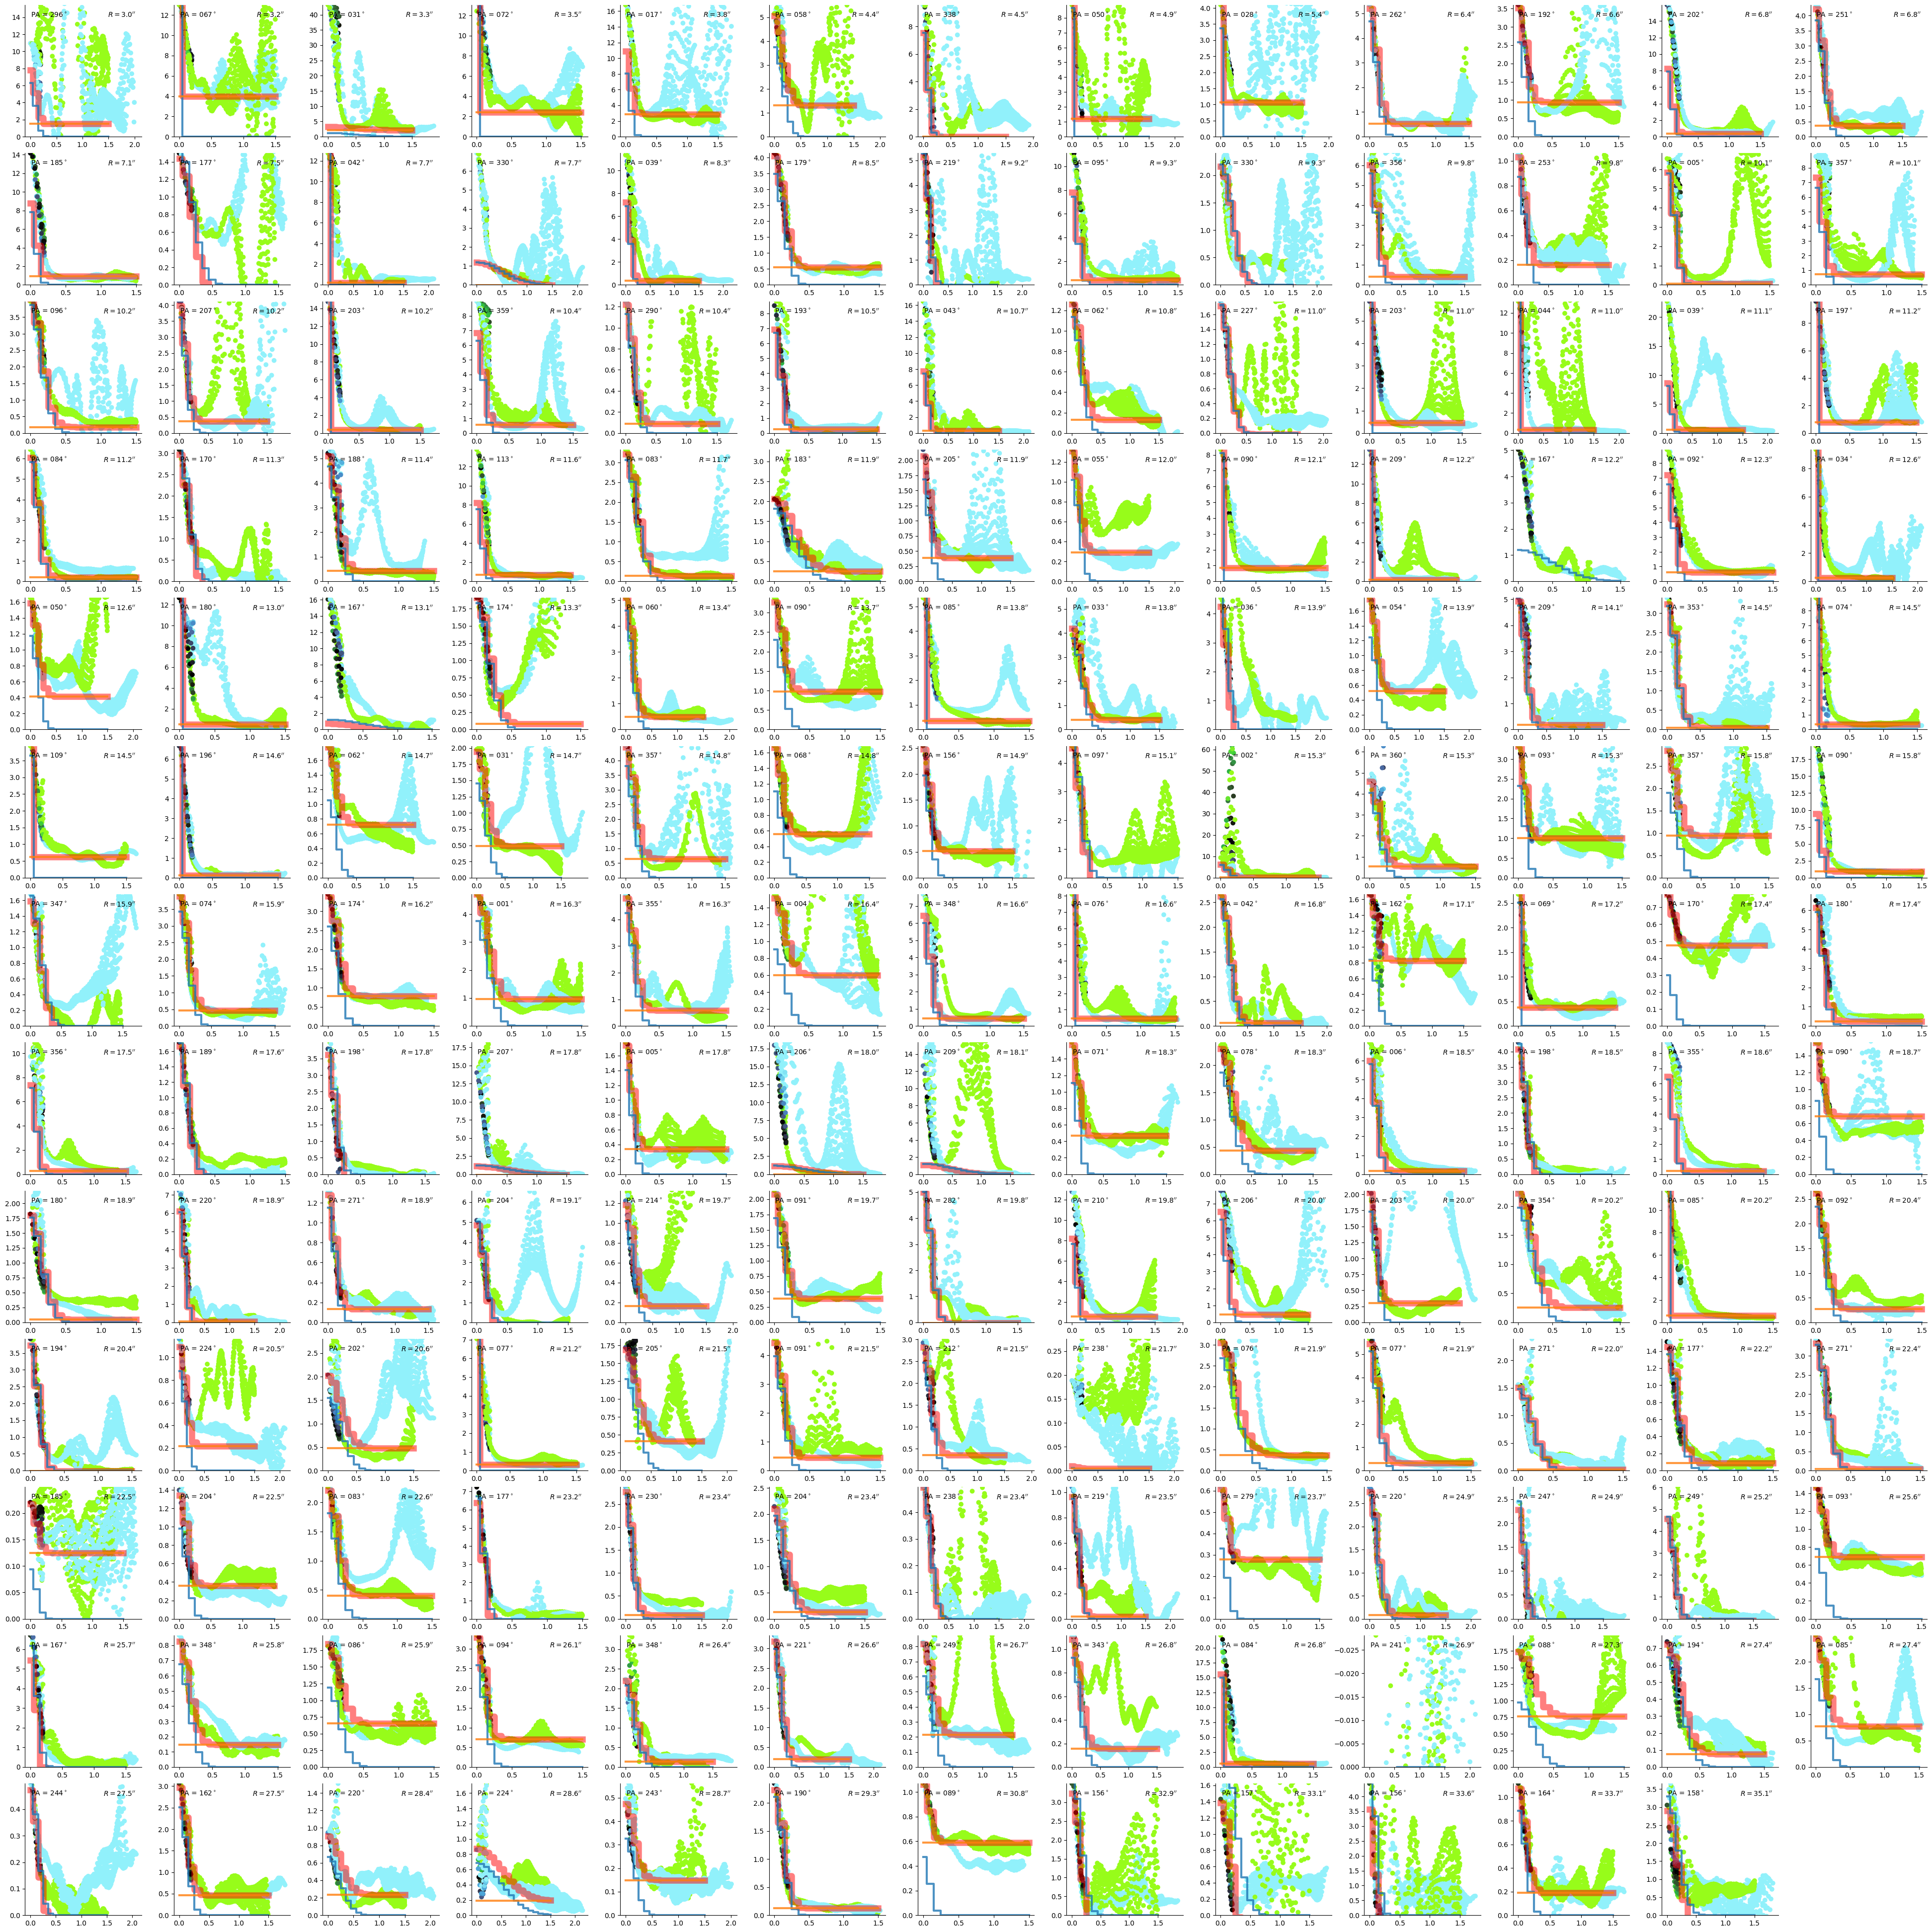

In [14]:
fig = plt.figure(figsize=(39, 39))
for idx, cutout in enumerate(cutouts):
    ax = fig.add_subplot(13, 13, idx + 1)
    m = cutout.mask
    ax.scatter(
        cutout.r[m].arcsec, 
        cutout.image[m], 
        c=Angle(cutout.pa - cutout.pa_star).wrap_at(180*u.deg).deg[m], 
        vmin=-60, vmax=60,
        cmap=cm.seaweed)
    
    rgrid = np.linspace(0.0, 1.5, 16)
    ax.plot(rgrid, cutout.fitted(rgrid), drawstyle="steps-mid", linewidth=9, c='r', alpha=0.5)
    for component in cutout.fitted:
        ax.plot(rgrid, component(rgrid), drawstyle="steps-mid", linewidth=3, alpha=0.8)

    plt.ylim(0,cutout.bright_peak)

    ax.text(0.05, 0.95, rf'PA = {round(cutout.pa_source.value):03d}$^\circ$', transform=ax.transAxes, va="top", ha="left")
    ax.text(0.95, 0.95, rf"$R = {cutout.sep.value:.1f}''$", transform=ax.transAxes, va="top", ha="right")
    ax.set(xlabel="", ylabel="", ylim=[0.0, None])
sn.despine()
fig.tight_layout(h_pad=0.3, w_pad=0.3)

Vemos que en algunos casos no lo es, y se debe al simple hecho de que tenemos un mal ajuste.

Tenemos dos casos, uno en el que el radio es demasiado peuqueño y su contraparte en el que los radios son muy grandes. 

Esto se debió a varios factores, una de ellas fue por la difracción del telescopio la cual afectó a los dos casos ante mencionados. Para el caso de los radios pequeños es porque la emisión en ocasiones era muy baja comparada con la del entorno por lo que costaba un poco decidir el radio. Mientras que en el caso de que los radios eran muy grandes era precisamente por la emisión de otras fuentes, si bien se trató de resolver haciendo que decayera con el radio y que la emisión estuviera principalmente en el círculo pequeño de la máscara en algunas ocasiones esto era imposible.

Esto se reolvió viendo tanto en sus ajustes como en su máscara para darles un radio razonablemente bien. _fue hecho artesanalmente a mano_

In [15]:
''' indices de los globulos cuyos radios están mal '''
indi = [
    1,2,3,7,8,15,16,28,35,36,38,47,48,49,51,53,54,58,64,65,66,85,88,94,96,97,115,120,151,159
]

''' el nuevo valor que se les encontró '''
n_val = [
    0.12,0.2,0.13,0.13,0.11,0.2,0.17,0.17,0.1,0.15,0.14,0.09,0.13,0.11,0.13,0.11,0.12,0.12,0.17,0.12,0.11,0.1,0.09,0.12,0.12,0.11,0.13,0.11,0.08,0.1
]

len(n_val)==len(indi)

True

In [16]:
for i in range(len(indi)):
    results_table['Rcore'][indi[i]]=n_val[i]*u.arcsec

In [17]:
results_table

<QTable length=168>
   PA     Sep    Bcore    Bbg    Rcore 
  deg    arcsec                  arcsec
float64 float64 float64 float64 float64
------- ------- ------- ------- -------
 296.28    2.98    6.28    1.50    0.09
  66.87    3.15   15.00    3.98    0.12
  30.92    3.31    1.19    2.06    0.20
  71.97    3.52   15.00    2.43    0.13
  16.83    3.80    8.04    2.89    0.07
  57.69    4.38    3.74    1.32    0.16
    ...     ...     ...     ...     ...
  88.55   30.80    0.47    0.59    0.08
 156.45   32.85    3.87   -0.63    0.15
 157.04   33.10    2.35   -0.97    0.22
 155.78   33.61    5.52   -1.95    0.10
 163.51   33.67    0.88    0.19    0.11
 158.04   35.10    3.30   -0.40    0.18

Text(0.5, 1.0, 'Distribución de los nuevos radios r_0')

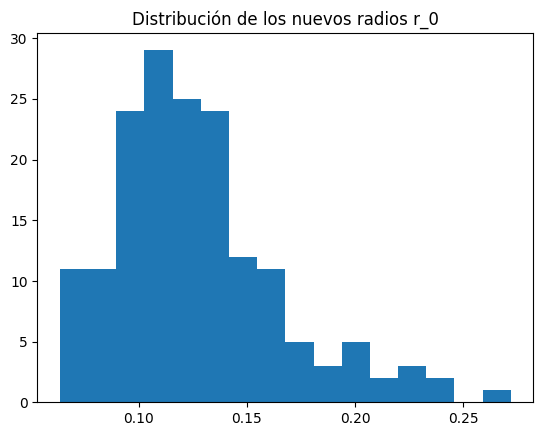

In [20]:
plt.hist(results_table['Rcore'],bins=16)
plt.title('Distribución de los nuevos radios r_0')

In [21]:
results_table.write("r0.ecsv", overwrite=True)